In [1]:
import torch
import torchvision.transforms as transforms
import torchvision
import pylab as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import seaborn as sns
import pandas as pd
device

device(type='cuda', index=0)

In [2]:
def loss_dataset(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            total += y.size(0)
            correct += loss.item()
    return correct * 1.0 / total

def accuracy_batch(model, X, y):
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)
    return (predicted == y).sum().item() / y.size(0)

def loss_batch(model, X, y):
    outputs = model(X)
    return criterion(outputs, y).item() / y.size(0)
    
def accuracy_dataset(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct * 1.0 / total

def optimize(model, optimizer, train_data, val_data, epochs, log_file="log.csv", model_file="nn.chkp"):
    best_loss = float("inf")
    log = pd.DataFrame(columns=['step', 'metric', 'value'])
    
    for i in range(1, epochs+1):
        for j, (inputs, labels) in enumerate(train_data):
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        loss = loss_dataset(model, train_data)
        accuracy = accuracy_dataset(model, train_data)
        val_loss = loss_dataset(model, val_data)
        val_accuracy = accuracy_dataset(model, val_data)
        print("step: %i, loss: %f, accuracy: %f, Validation loss: %f, Validation accuracy: %f" % (i, loss, accuracy, val_loss, val_accuracy))
        log = log.append({"step":i, "metric":"train_loss", "value": loss}, ignore_index=True)
        log = log.append({"step":i, "metric":'train_accuracy', "value": accuracy}, ignore_index=True)
        log = log.append({"step":i, "metric":"val_loss", "value": val_loss}, ignore_index=True)
        log = log.append({"step":i, "metric":'val_accuracy', "value": val_accuracy}, ignore_index=True)
        if(val_loss < best_loss):
            best_loss = val_loss
            torch.save(model.state_dict(), model_file)
    log.to_csv(log_file, index=False)


In [9]:
%%time
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)
#         self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         print(np.shape(x))
        x = self.pool(F.relu(self.conv2(x)))
#         print(np.shape(x))
        x = self.pool(F.relu(self.conv3(x)))
#         print(np.shape(x))
        x = self.pool(F.relu(self.conv4(x)))
    
#         x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

epochs = 50
batch_size=1024
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

valset, testset = torch.utils.data.random_split(testset, [5000, 5000])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=6)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=6)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

log_file = 'logs/torch_log.csv'
model_file = 'models/torch_model.chkp'



optimize(model, optimizer, trainloader, valloader, epochs, log_file=log_file, model_file=model_file)

Files already downloaded and verified
Files already downloaded and verified
step: 1, loss: 0.002256, accuracy: 0.100000, Validation loss: 0.002302, Validation accuracy: 0.103800
step: 2, loss: 0.002254, accuracy: 0.113180, Validation loss: 0.002300, Validation accuracy: 0.117400
step: 3, loss: 0.002251, accuracy: 0.206700, Validation loss: 0.002297, Validation accuracy: 0.213800
step: 4, loss: 0.002242, accuracy: 0.222020, Validation loss: 0.002287, Validation accuracy: 0.223800
step: 5, loss: 0.002169, accuracy: 0.198600, Validation loss: 0.002211, Validation accuracy: 0.201000
step: 6, loss: 0.001991, accuracy: 0.256740, Validation loss: 0.002022, Validation accuracy: 0.264400
step: 7, loss: 0.001884, accuracy: 0.292340, Validation loss: 0.001910, Validation accuracy: 0.308000
step: 8, loss: 0.001753, accuracy: 0.340100, Validation loss: 0.001775, Validation accuracy: 0.354400
step: 9, loss: 0.001625, accuracy: 0.381960, Validation loss: 0.001646, Validation accuracy: 0.399600
step: 

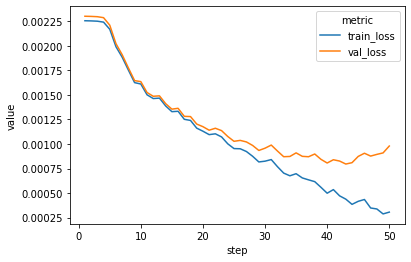

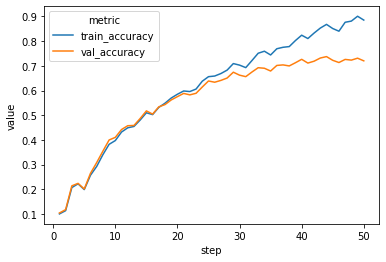

In [10]:
training_trajectory = pd.read_csv(log_file)
training_trajectory.head()
for x in set(map(lambda x: x.split('_')[1], training_trajectory['metric'].unique())):
    data = training_trajectory[training_trajectory['metric'].str.contains(x)]
    sns.lineplot(data=data, x='step', y='value', hue='metric')
    plt.show()

In [11]:
model = Net().to(device)
model.load_state_dict(torch.load(model_file))
model.eval()

accuracy_dataset(model, testloader)

0.7316